In [2]:
from keras.utils import plot_model
import prophet as ph
import pandas as pd
import numpy as np
import time

Using TensorFlow backend.


## Plot nets

In [3]:
plot_model(ph.prophet1(), to_file='ph1.png', show_shapes=True)
plot_model(ph.prophet2(), to_file='ph2.png', show_shapes=True)

## Data generator

In [360]:
import requests
def bitfinex(tf, pair, start, end, limit=5000):
    url = f'https://api.bitfinex.com/v2/candles/trade:{tf}:t{pair}/hist?&start={start}&end={end}'
    request = requests.get(url)
    response = request.json()
    points = []
    if isinstance(response, list) :
        count = 0 
        for row in response:  
            json_body = {
                        "tstmp": int(row[0]),
                        "open": float(row[1]),
                        "close": float(row[2]),
                        "high": float(row[3]),
                        "low": float(row[4]),
                        "volume": float(row[5]),
                        }
            points.append(json_body)
    print('Info:    ', end, response[-1])
    return pd.DataFrame(points)

In [ ]:
tfs = ['1h', '3h', '6h', '12h']
pairs = ['NEOUSD', 'ETHUSD', 'LTCUSD']

for p in pairs:
    for t in tfs:
        end = 1546300800
        df = bitfinex(t, p, (end - 5000*60)*1000, (end)*1000)
        time.sleep(3)
        for i in range(1,300):
            try:
                tmp = bitfinex(t, p, (end - (i+1)*5000*60)*1000, (end - i*5000*60)*1000)
                df = pd.concat([df, tmp], ignore_index=True)
                time.sleep(7)
            except:
                pass
        df = df.drop_duplicates()
        df.to_pickle(f'{p}:{t}_full.pkl')

Info:     1546300800000 [1546002000000, 7.1677, 7.22575623, 7.2297, 7.0769, 20252.89557212]
Info:     1546000800000 [1545703200000, 7.8111, 7.8672, 7.8932, 7.7408, 11871.21078686]
Info:     1545700800000 [1545400800000, 7.4691, 7.4375, 7.4691, 7.356, 9040.62186569]
Info:     1545400800000 [1545102000000, 6.64, 6.7908, 6.7909, 6.627, 25974.78620619]
Info:     1545100800000 [1544803200000, 5.6793, 5.6151, 5.6913, 5.5555, 31440.370386]
Info:     1544800800000 [1544500800000, 6.1919, 6.2493, 6.3, 6.1885, 8932.666649]
Info:     1544500800000 [1544202000000, 5.6098, 5.5955, 5.6516, 5.4645, 28691.71705254]
Info:     1544200800000 [1543903200000, 7.1302, 7.7132, 7.7762, 7.0599, 65577.133688]
Info:     1543900800000 [1543600800000, 8.0134, 7.9114, 8.0199, 7.9, 6179.58997584]
Info:     1543600800000 [1543302000000, 7.1856, 7.0929, 7.2123, 6.9047, 60926.61323604]
Info:     1543300800000 [1543003200000, 8.3884, 8.3208, 8.3884, 8.3, 9307.65826102]


In [6]:
# timeframes = ['1h', '3h', '6h', '12h', '24h']
# pairs = ['BTCUSD', 'NEOUSD', 'ETHUSD', 'LTCUSD']

# for p in pairs:
#     for t in timeframes:
#         try:
#             df = bitfinex(t, p)
#             df.to_pickle(f'bitfinex_{p}:{t}.pkl')
#             time.sleep(4)
#         except:
#             print(f'Failed: {p}:{t}')
#             pass

Failed: BTCUSD:24h
Failed: NEOUSD:24h
Failed: ETHUSD:24h
Failed: LTCUSD:24h


## Helpers

In [267]:
def make_observations(df, size: int):
    assert df.shape[1] == 4
    assert df.shape[0] >= size+1
    # determine how many records
    imput_thr = int(np.floor(df.shape[0]/(size+1)))
    df = df.iloc[:(size+1)*imput_thr, :] 
    df = df.values.reshape(imput_thr, size + 1, 4)
    
    output = []
    for arr in df:
        x, M, m = normalize_price(arr[:-1])
        y = (arr[-1][0] - m)/(M-m)
#         output.append([x.reshape(size, 4, 1), y, M, m])
        output.append([x, y, M, m])
    
    df = pd.DataFrame(output, columns=['x', 'y', 'M', 'm'])
    return df
    

def normalize_price(arr):
    M = np.max(arr)
    m = np.min(arr)
    d = M - m
    output = (arr - m)/d 
    return output, M , m

def reverse_norm(arr: np.array, M, m):
    d = M-m
    arr = d * arr + m
    return arr

                

## Import data

In [322]:
p = 'BTCUSD'
t = '1h'
df = bitfinex(t, p)
df.head(5)

,close,high,low,open,volume
0,3513.081537,3518.23739,3511.362924,3518.100000,53.145009
1,3517.900000,3522.80000,3510.600000,3510.675477,309.749905
2,3510.675477,3512.30000,3498.759732,3510.000000,428.283666
3,3509.900000,3517.60000,3502.700000,3517.300000,239.337868
4,3517.206221,3523.10000,3508.269410,3523.100000,906.105317


In [324]:
df.shape

(5000, 5)

In [423]:
df = pd.read_pickle('BTCUSD1h_full.pkl')
df = make_observations(df.iloc[:, :4], 20)
df.head()

,x,y,M,m
0,"[[0.3687557654597703, 0.43218390804597595, 0.2...",0.752874,3945.0,3771.0
1,"[[0.3263979193758112, 0.36345903771131355, 0.2...",0.289337,4003.8,3850.0
2,"[[0.24118098159509263, 0.28374233128834386, 0....",0.541028,4099.7,3838.9
3,"[[0.8260869565217392, 0.9714850367024283, 0.77...",0.010638,4095.0,3740.8
4,"[[0.29989094874591044, 0.4307524536532168, 0.1...",0.948885,3869.4,3686.0


## Models

In [221]:
from sklearn.model_selection import train_test_split

In [424]:
X_train, X_test, y_train, y_test = train_test_split(df.x.values, df.y.values, test_size=0.2, random_state=42)
X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])
X_train.shape

(1261, 20, 4)

In [425]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout, Activation, Concatenate, Input, LSTM, CuDNNLSTM, concatenate, Reshape


def OHLC_prophecy(ts_input_shape,
                lstm_size = 32,
                lstm_dense = 32,
                size_dense=64,
                num_dense=2,
                p_loss='mean_squared_error',
                p_optimizer='sgd',
                use_gpu_specifics=False):
    """
    Uses OHLC input
    """

    # Declare inputs
    net_input = Input(shape=(ts_input_shape, 4))
    
    # Build the ts_part of the network
    if use_gpu_specifics:
        lstm_out = CuDNNLSTM(lstm_size)(net_input)
    else:
        lstm_out= LSTM(lstm_size)(net_input)

    # Denses
    dense_out = Dense(size_dense)(lstm_out)
    for _ in range(num_dense):
        dense_out = Dense(size_dense)(dense_out)

    # Output dense
    output = Dense(1, activation='linear')(dense_out)
    
    model = Model(inputs=ts_input, outputs=output)
    model.compile(loss=p_loss, optimizer=p_optimizer)

    return model

In [430]:
model = prophetOHLC(ts_input_shape=X_train[0].shape[0], lstm_size=200, num_dense=12)

In [431]:
results = model.fit(
 X_train, y_train,
 epochs= 20,
 batch_size = 200
)

Epoch 1/20
1261/1261 [==============================] - 3s 2ms/step - loss: 0.1524
Epoch 2/20
1261/1261 [==============================] - 1s 839us/step - loss: 0.0612
Epoch 3/20
1261/1261 [==============================] - 1s 817us/step - loss: 0.0482
Epoch 4/20
1261/1261 [==============================] - 1s 838us/step - loss: 0.0378
Epoch 5/20
1261/1261 [==============================] - 1s 850us/step - loss: 0.0311
Epoch 6/20
1261/1261 [==============================] - 1s 837us/step - loss: 0.0275
Epoch 7/20
1261/1261 [==============================] - 1s 851us/step - loss: 0.0257
Epoch 8/20
1261/1261 [==============================] - 1s 819us/step - loss: 0.0252
Epoch 9/20
1261/1261 [==============================] - 1s 853us/step - loss: 0.0244
Epoch 10/20
1261/1261 [==============================] - 1s 900us/step - loss: 0.0238
Epoch 11/20
1261/1261 [==============================] - 1s 1ms/step - loss: 0.0231
Epoch 12/20
1261/1261 [==============================] - 1s 844us/s

## Plots / tests

In [380]:
import matplotlib.pyplot as plt

In [432]:
n = 40
y_hat = model.predict(X_test[:n])
y_hat = y_hat.reshape(y_hat.shape[0])
y = y_test[:n]
dy = y - y_hat

In [433]:
model.evaluate(X_test, y_test)

316/316 [==============================] - 1s 2ms/step


0.017257114660136307

In [434]:
[(a,b) for a, b in zip(y, y_hat)]

[(0.9350828729281732, 0.674567),
 (0.03625309614951621, 0.17235373),
 (0.858096828046741, 0.69620025),
 (0.3959090909090905, 0.2804504),
 (0.07193877551020594, 0.08129484),
 (0.5992907801418416, 0.6090945),
 (0.399180327868851, 0.30921268),
 (0.8656167979002606, 0.797081),
 (0.4875283446712028, 0.3981604),
 (0.0021660649819507717, 0.0094647985),
 (0.4340704340704344, 0.6015583),
 (0.993150684931513, 0.904654),
 (0.7207547169811287, 0.8534678),
 (0.46808510638297746, 0.4356846),
 (0.5076748152359257, 0.73187923),
 (0.14875776397515555, 0.08771428),
 (0.09567496723460026, 0.11222233),
 (0.8342391304347793, 0.8234515),
 (0.46618705035971353, 0.5132088),
 (0.891251174216294, 0.8594855),
 (0.9405487804878048, 0.9351851),
 (0.18647540983605923, 0.27945498),
 (0.7122448979591824, 0.5799827),
 (0.031045751633986533, 0.15435427),
 (0.7053140096618419, 0.47051314),
 (0.549937016375742, 0.61438966),
 (0.8231023102310261, 0.70379),
 (0.6765893791651321, 0.7196429),
 (0.977687626774848, 0.9180189),

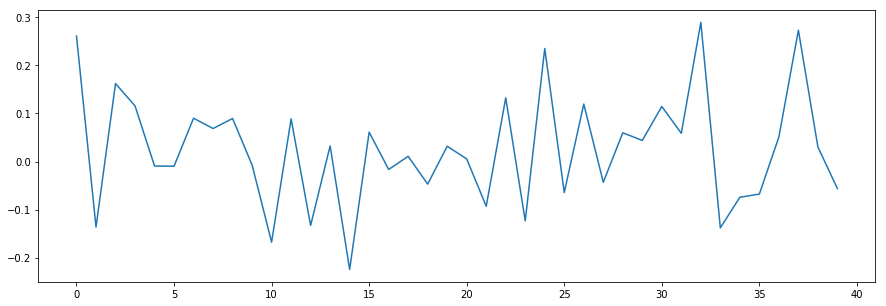

In [435]:
plt.figure(figsize=(15, 5))
plt.plot(dy)
plt.show()

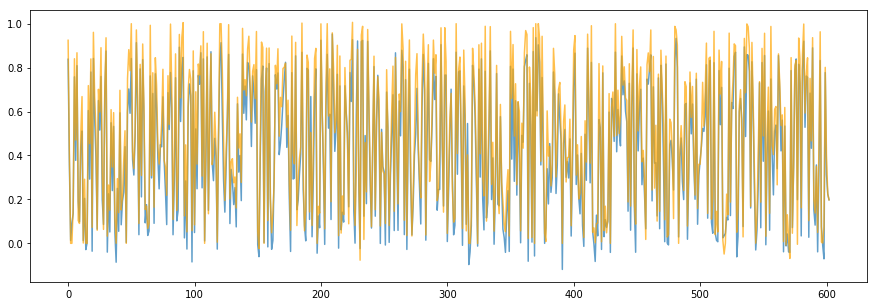

In [400]:
plt.figure(figsize=(15, 5))
# x = np.arange(y_hat.size)
plt.plot(y_hat, alpha=0.7)
plt.plot(y, color='orange', alpha=0.7)
plt.show()

In [300]:
X_test

        close      high       low      open    volume
100  0.232011  0.249339  0.226323  0.226455  0.026604
101  0.226455  0.251984  0.225265  0.238990  0.025488
102  0.238889  0.241931  0.219180  0.224074  0.046583
103  0.224251  0.259392  0.178175  0.192109  0.189599
104  0.192063  0.192725  0.186508  0.191799  0.015582 (600, 5)


In [302]:
def gaze(x:np.array, size=50):
    prophecy = [model.predict([[close[i:i+size]]])[0][0] for i in range(x.size-size)]
    return np.array(prophecy)
    

<function matplotlib.pyplot.show(*args, **kw)>

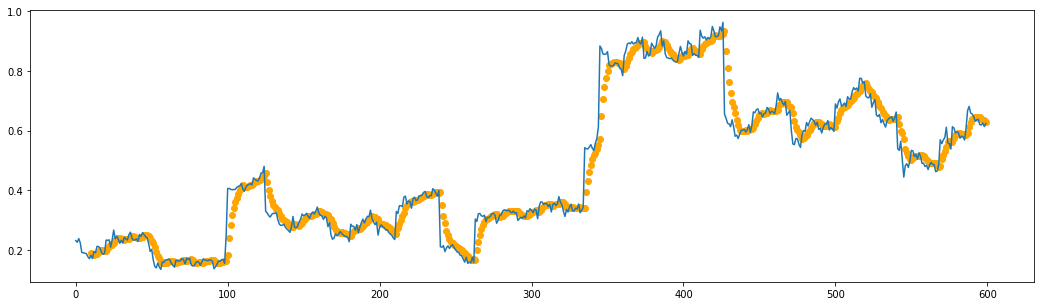

In [307]:
size = 10
close_hat = gaze(close, size)

plt.figure(figsize=(18, 5))
plt.plot(close)
x = np.arange(close_hat.size)+size
plt.scatter(x, close_hat, color='orange')
plt.show

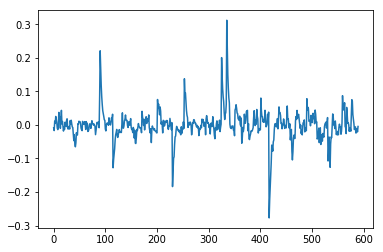

mean  0.0005380244419236621


In [327]:
real_close = close[size:].reshape(1, close[size:].shape[0])[0]
dif = (real_close-close_hat)
plt.plot(dif)
plt.show()

print('mean ', np.mean(dif))

In [335]:
direction = np.array([1 if x/y >= 1 else 0 for x,y in zip(real_close[1:], real_close[:-1])])
direction_hat = np.array([1 if x/y >= 1 else 0 for x,y in zip(close_hat[1:], close_hat[:-1])])

In [342]:
diff = direction-direction_hat
print('Points with different dir :'   , len([x for x in diff if x==-1])/diff.size)
print('Difference :'   , np.sum(direction-direction_hat))
np.sum(direction-direction_hat)/direction.size


Points with different dir : 0.300509337860781
Difference : -36


-0.06112054329371817